## ML models

This notebook trains the following ML models:

1. Logistic Regressor
2. Decision Tree
3. Support-Vector Machine
4. K-Nearest Neighbours
5. Random Forests

as well as two boosting methods:

1. Extreme Gradient Boosting Machine
2. Light Gradient Boosting Machine

In [39]:
import optuna
from loguru import logger
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import (LGBMClassifier as lgb, plot_importance)
from xgboost import XGBClassifier as xgb

from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score, classification_report, mean_squared_error, roc_auc_score, confusion_matrix)
from sklearn.model_selection import (cross_validate, RepeatedStratifiedKFold, cross_val_score, train_test_split)

In [12]:
log_dir = '../logs'

In [5]:
def get_data(name:str='', SHUFFLE_FLAG:bool=False, NORM_FLAG:bool=True, random_state:int=42):
    '''
    Function to select data

    Arguments
    ---------
    name: str, (required)
        name of dataset to be returned
    SHUFFLE_FLAG: bool, (optional)
        Flag for if the data should be shuffled
    NORM_FLAG: bool, (optional)
        If the data should be normalized
    random_state: int, (optional)
        random_state
    
    Returns
    -------
    X: numpy.ndarray 
        training set 
    y: numpy.ndarray 
        test set
    '''
    
    if name is None or name not in ['gaia']:
        raise ValueError("Required argument 'name' is missing.")
    
    if name == "gaia":
        dir = '../data/Gaia DR3/gaia_lm_m_stars.parquet'
        data = pd.read_parquet(dir)
        if SHUFFLE_FLAG:
            df = shuffle(data)
        else:
            df = data
        X = np.vstack(df['flux'])
        y = np.vstack(df['Cat'])
        
        y = np.where(y == 'M', 1, y)
        y = np.where(y == 'LM', 0, y)

        y = y.astype(int)

        if NORM_FLAG:
            norm = np.linalg.norm(X,keepdims=True)
            X = X/norm
            

    elif name == 'apogee':
        dir = '../data/APOGEE'
        train_dir = dir + '/training_data.h5'
        test_dir = dir +'/test_data.h5'

        with h5py.File(train_dir, 'r') as f:
            X = f['spectrum'][:]
            y = np.hstack((f['TEFF'],
                        f['LOGG'],
                        f['FE_H']))
        
        #TODO: add shuffle

        if NORM_FLAG:
            norm_dir = dir + '/mean_and_std.npy'
            norm_data = np.load(norm_dir)
            
            mean = norm_data[0]
            std = norm_data[1]
            y = (y-mean)/std

    return X, y

Total number of spectra: 17627
Number of bins in each spectra: 343
In the dataset, we have 11026 spectra for low mass stars and 6601 spectra for high mass stars.


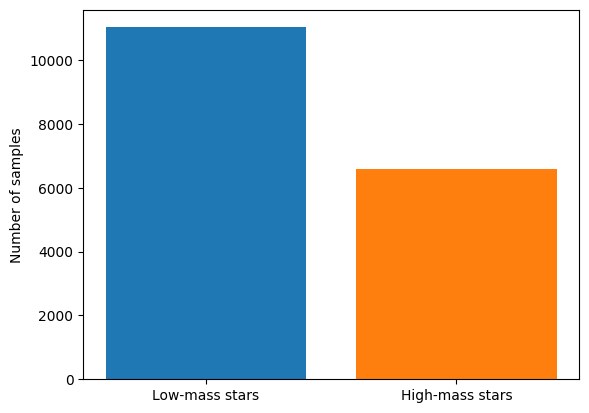

In [51]:
X, y = get_data('gaia', SHUFFLE_FLAG=True)
#X, y = get_data('apogee')

num_samples = X.shape[0]
spectrum_width = X.shape[1]

num_samples_m = np.count_nonzero(y)
num_samples_lm = len(y) - num_samples_m
num_classes = len(np.unique(y))

print("Total number of spectra:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

plt.bar(["Low-mass stars", "High-mass stars"],[num_samples_lm, num_samples_m], color=['#1f77b4', '#ff7f0e'])
plt.ylabel("Number of samples")
plt.show()

In [ ]:
#naive splitting methods, not used in this notebook

split = 0.8

train_size = int(split * num_samples)

x_train, x_test = np.split(X, [train_size])
y_train, y_test = np.split(y, [train_size])

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [11]:
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

## Logistic Regression

In [36]:
# training with no hyperparamater tuning

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression()
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

2024-05-09 15:34:55.927 | INFO     | __main__:<module>:27 - Cross-validation technique:RepeatedStratifiedKFold,            Number of repeats:2,            Number of splits:10,            Time taken:1.4197499752044678,            ROC-AUC scores:[0.9466990851397017, 0.9402016538915904, 0.9445053435533943, 0.9518530728866178, 0.9447622187422732, 0.9453556416385065, 0.9367687961099473, 0.9474220425672331, 0.9455219160754551, 0.9482139910905791, 0.9351342069837083, 0.95045743014918, 0.9472499244484739, 0.9503310530509078, 0.9424640786834803, 0.9485027061182999, 0.9382322335129911, 0.9410012099213552, 0.9477685200461969, 0.9509541879777814],            Mean ROC-AUC score:0.9451699656293837,            Accuracy:[0.6256381168462848, 0.6256381168462848, 0.6256381168462848, 0.6256381168462848, 0.6256381168462848, 0.6256381168462848, 0.6250709018718095, 0.6254256526674233, 0.6254256526674233, 0.6254256526674233, 0.6256381168462848, 0.6256381168462848, 0.6256381168462848, 0.6256381168462848, 0.625

Mean ROC-AUC score: 0.9451699656293837
Mean accuracy: 0.625517656095179


## Decision Trees

In [9]:
# training with no hyperparamater tuning

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = DecisionTreeClassifier()
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

0.8856353013784883
0.9263065259338283


In [38]:
def objective(trial):
    return

## Random Forest

In [ ]:
# training with no hyperparamater tuning

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestClassifier()
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1 , 50)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    rkf = RepeatedStratifiedKFold(n_splits = 5)
    score = cross_val_score(model, x_train, y_train.squeeze(1), cv=rkf, scoring='accuracy')

    return score


study = optuna.create_study(direction='maximize', study_name='xgb_model_training')
study.optimize(objective, n_trials=100)

## Support-Vector Machines

In [ ]:
# training with no hyperparamater tuning

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression()
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

In [37]:
def objective(trial):
    return

## K-Nearest Neighbours

In [ ]:
# training with no hyperparamater tuning

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = KNeighborsClassifier()
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

In [ ]:
def objective(trial):
    return

## Light Gradient Boosting Machine

In [ ]:
#-------------------initial naive implementation, needs a lot more tuning-------------------------------

# training with no hyperparamater tuning

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = lgb(n_estimators=1200, random_state=42, learning_rate = 0.01,reg_lambda=50, min_child_samples=2400, num_leaves=95, colsample_bytree=0.19, max_bins=65, device='gpu')
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

In [ ]:
#check overfitting
y_pred_train = model.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(accuracy, acc_train)

In [ ]:
def objective(trial):
    return

## Extreme Gradient Boosting Machine

In [ ]:
#-------------------initial naive implementation, needs a lot more tuning-------------------------------

accuracy_scores = []
roc_auc_scores = []
st = time.time()
for train_idx, test_idx in kfold.split(X, y):
    
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = xgb(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5, device='gpu')
    model.fit(x_train, y_train.squeeze(1))

    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test.squeeze(1), y_pred)
    ra_score = roc_auc_score(y_test.squeeze(1), y_probs)

    roc_auc_scores.append(ra_score)
    accuracy_scores.append(accuracy)

print("Mean ROC-AUC score:",np.mean(roc_auc_scores))
print("Mean accuracy:",np.mean(accuracy_scores))

log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
logger.add(log_file, format="{time} - {level} - {message}")
logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
            Number of repeats:{kfold.__dict__['n_repeats']},\
            Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
            Time taken:{time.time()-st},\
            ROC-AUC scores:{roc_auc_scores},\
            Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
            Accuracy:{accuracy_scores},\
            Mean accuracy:{np.mean(accuracy_scores)}")

In [ ]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree','gblinear']),
        'device': 'cuda',
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise','lossguide']),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'gamma' : trial.suggest_float('gamma', 1e-5, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }

    params['n_estimators'] = 3000
    params['early_stopping_rounds'] = 50
    params['booster'] = 'gbtree'
    params["verbosity"] = 0
    params['tree_method'] = "hist"
    
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):

        X_train_fold, X_valid_fold = pd.DataFrame(X).iloc[train_idx], pd.DataFrame(X).iloc[valid_idx]
        y_train_fold, y_valid_fold = pd.Series(y.squeeze(1)).iloc[train_idx], pd.Series(y.squeeze(1)).iloc[valid_idx]
                
        # Create and fit the model
        model = xgb(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)],verbose=False)

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(pd.Series(y.squeeze(1)).iloc[valid_idx], y_prob.squeeze(1), multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize', study_name='xgb_model_training')
study.optimize(objective, n_trials=200)